# NDB1 Analysis

In this notebook we analyse the results from NDB1 experiment (`script_06.py`).

We leverage [set intersection metrics](https://effectivesoftwaredesign.com/2019/02/27/data-science-set-similarity-metrics/).

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## (Experiment ID=2, script_06) NDB1 with no hyperparameter tuning

In [159]:
df2 = pd.read_csv(
    "../data/mlflow_experiment2_runs.tsv", 
    sep='\t',
    dtype={"ag_pos": str, "ag_neg": str}
    )
df2["ag_pos"] = df2["ag_pos"].replace("5E+094", "5E94")
df2["ag_neg"] = df2["ag_neg"].replace("5E+094", "5E94")
df2["ag_pair"] = df2["ag_pos"] + "_" + df2["ag_neg"]
df2 = df2.loc[df2["Name"] == "run_2"].iloc[:15]
df2["test_acc"] = df2["test_acc"] / 100
print(df2.shape)
print(df2.columns)
df2.head(2)

(15, 28)
Index(['Start Time', 'Duration', 'Run ID', 'Name', 'Source Type',
       'Source Name', 'User', 'Status', 'N_closed', 'N_open', 'N_train',
       'ag_neg', 'ag_pos', 'batch_size', 'epochs', 'learning_rate', 'momentum',
       'optimizer_type', 'weight_decay', 'closed_f1', 'closed_precision',
       'closed_recall', 'closed_roc_auc', 'open_roc_auc', 'test_acc',
       'test_loss', 'train_loss', 'ag_pair'],
      dtype='object')


,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,N_closed,N_open,...,weight_decay,closed_f1,closed_precision,closed_recall,closed_roc_auc,open_roc_auc,test_acc,test_loss,train_loss,ag_pair
0,2022-09-13 22:44:59,1.0h,8ad6dcfbb4f04a5095d42d02267353f1,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9111.0,131283.0,...,0.0,0.948823,0.951241,0.946417,0.990077,0.648281,0.949182,0.126579,0.130873,1NSN_1OB1
1,2022-09-13 22:44:59,1.0h,ba6bc6ef056b4e139d5568383f3dc71d,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9197.0,131283.0,...,0.0,0.974354,0.974922,0.973786,0.994036,0.730767,0.971295,0.098698,0.057250,1OB1_1WEJ


In [140]:
compairr = pd.read_csv("../data/CompAIRR/results/overlaps_d1_output.tsv", sep='\t', index_col=0)
compairr

,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94,OPENSET
#,,,,,,,,,,,
1ADQ,108197,2763,4036,2521,3100,3112,3872,7331,7957,4899,117186
1FBI,2763,135298,1631,3493,8600,13111,4282,3768,4304,11708,11386
1H0D,4036,1631,165873,3895,378,2512,30477,7965,5906,10339,180466
1NSN,2521,3493,3895,170687,30603,6606,1524,3608,11573,15259,10689
1OB1,3100,8600,378,30603,182923,11764,2045,2209,15462,31647,7400
1WEJ,3112,13111,2512,6606,11764,171387,2388,8193,29120,32231,15077
2YPV,3872,4282,30477,1524,2045,2388,176120,9292,7504,11709,189257
3RAJ,7331,3768,7965,3608,2209,8193,9292,81101,3747,8802,93120
3VRL,7957,4304,5906,11573,15462,29120,7504,3747,212995,24202,23042


In [161]:
def jaccard_index(
    ag1: str, 
    ag2: str, 
    pairwise: pd.DataFrame = compairr
    ) -> float:
    intersection = pairwise.loc[ag1, ag2]
    union = (
        pairwise.loc[ag1, ag1] 
        + pairwise.loc[ag2, ag2] 
        - intersection
    )
    return intersection / union

jaccard_index("1ADQ", "5E94")

0.015961242103274025

In [162]:
df2["jaccard_pos_neg"] = df2.apply(lambda s: jaccard_index(s["ag_pos"], s["ag_neg"]), axis=1)
df2["jaccard_pos_openset"] = df2.apply(lambda s: jaccard_index(s["ag_pos"], "OPENSET"), axis=1)
df2["jaccard_neg_openset"] = df2.apply(lambda s: jaccard_index(s["ag_neg"], "OPENSET"), axis=1)
df2["jaccard_closed_openset_sum"] = df2["jaccard_pos_openset"] + df2["jaccard_neg_openset"]

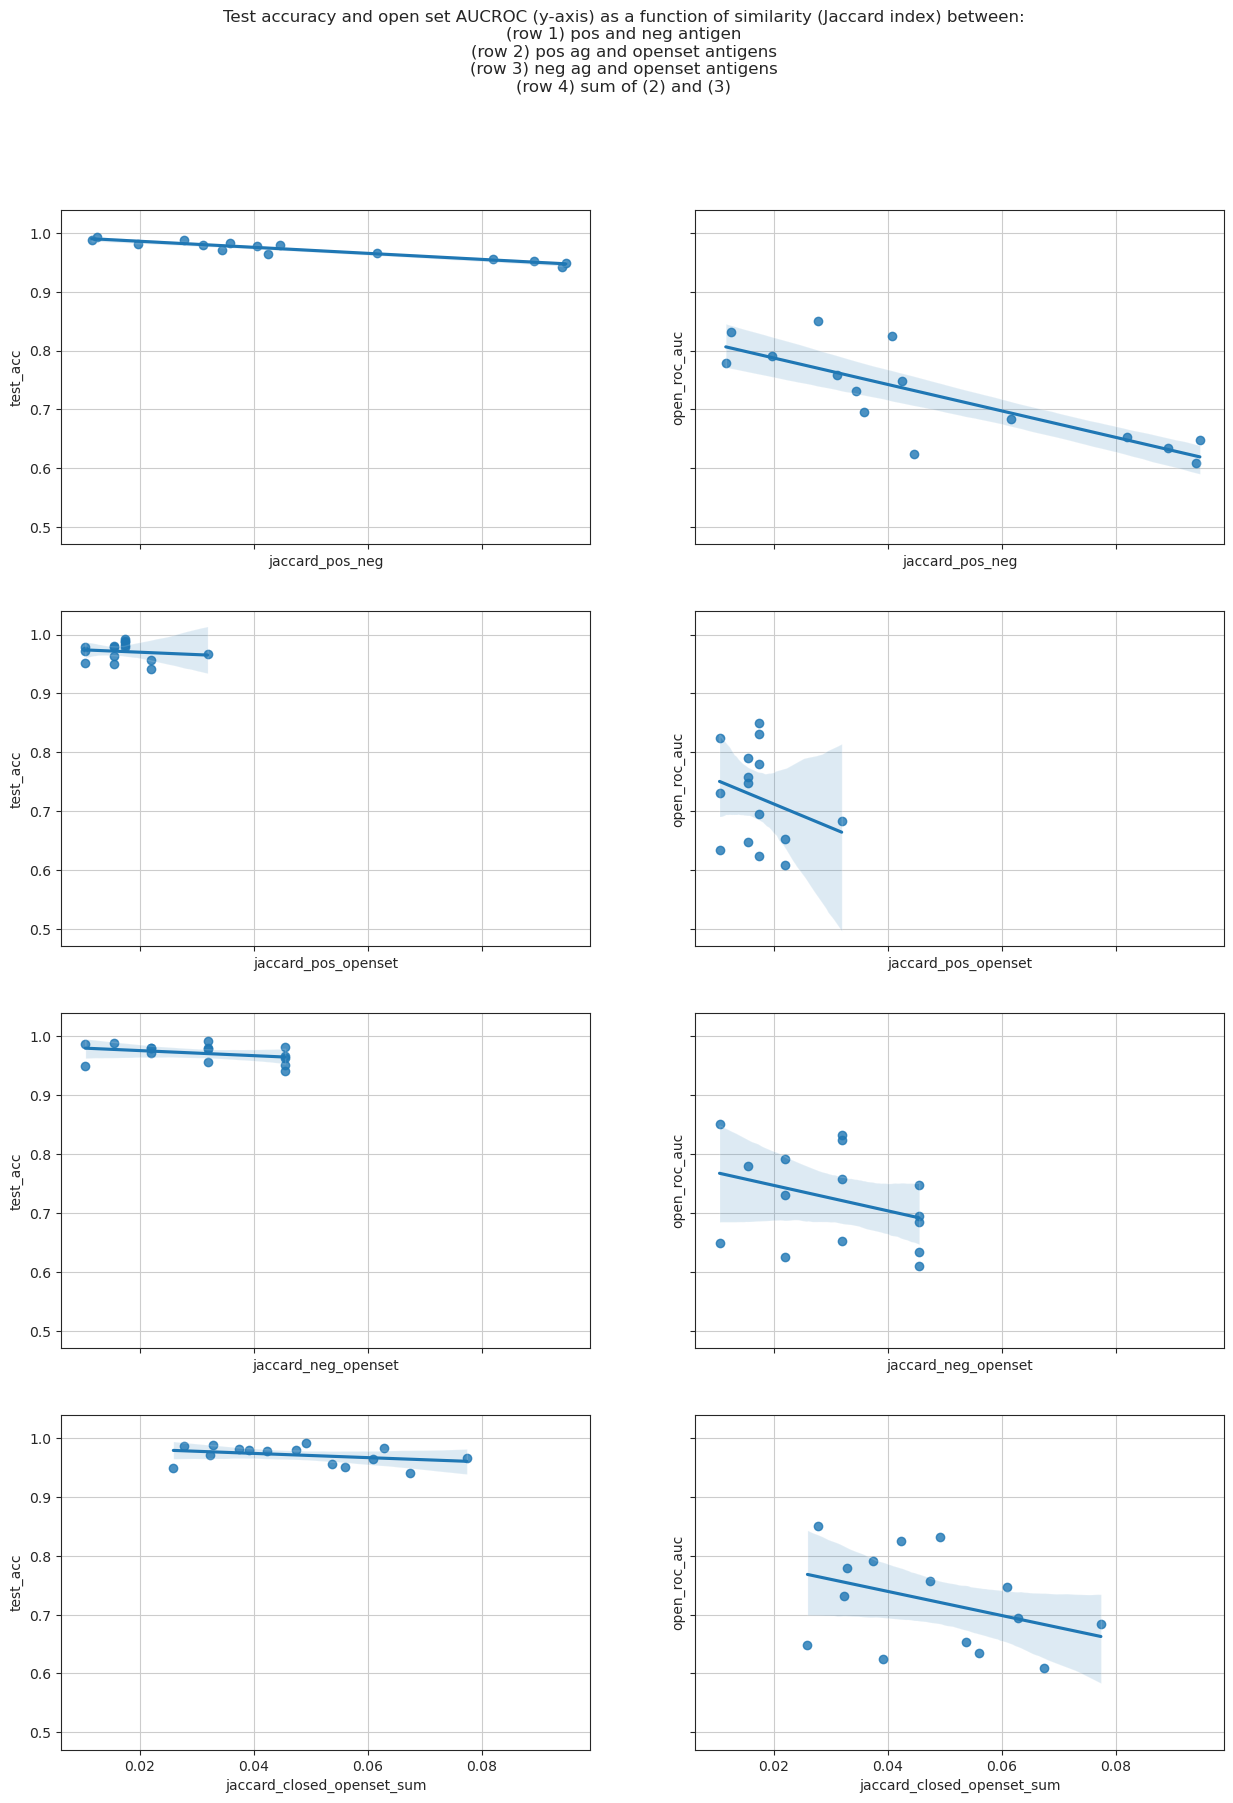

In [171]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20), sharex=True, sharey=True)

sns.regplot(data=df2, x="jaccard_pos_neg", y="test_acc", ax=axs[0][0])
sns.regplot(data=df2, x="jaccard_pos_neg", y="open_roc_auc", ax=axs[0][1])
sns.regplot(data=df2, x="jaccard_pos_openset", y="test_acc", ax=axs[1][0])
sns.regplot(data=df2, x="jaccard_pos_openset", y="open_roc_auc", ax=axs[1][1])
sns.regplot(data=df2, x="jaccard_neg_openset", y="test_acc", ax=axs[2][0])
sns.regplot(data=df2, x="jaccard_neg_openset", y="open_roc_auc", ax=axs[2][1])
sns.regplot(data=df2, x="jaccard_closed_openset_sum", y="test_acc", ax=axs[3][0])
sns.regplot(data=df2, x="jaccard_closed_openset_sum", y="open_roc_auc", ax=axs[3][1])

plt.suptitle(
    "Test accuracy and open set AUCROC (y-axis) "
    "as a function of similarity (Jaccard index) between:\n"
    "(row 1) pos and neg antigen\n"
    "(row 2) pos ag and openset antigens\n"
    "(row 3) neg ag and openset antigens\n"
    "(row 4) sum of (2) and (3)"
);

## (Experiment ID=3, script_06b) NDB1 with hyperparameter tuning

Hypotheses:
1. does openset roc improve with closedset roc due to cross-validation?
    - for each ag_pair, there is some relation between `closed_roc_auc` and `open_roc_auc`.
    - with time (optuna), the closed performance improves, wil the open performance does not.
    - do the tuned models perform better on the open set than untuned (from experiment ID=2)?
        - currently no, but there was an important difference: SGD vs Adam optimizer. Rerunning stage_06 to have meaningful comparison.

In [119]:
df = pd.read_csv("../data/mlflow_experiment3_runs.tsv", sep='\t')
df["ag_pos"] = df["ag_pos"].replace("5E+094", "5E94")
df["ag_neg"] = df["ag_neg"].replace("5E+094", "5E94")
df["ag_pair"] = df["ag_pos"] + "_" + df["ag_neg"]
df["Start Time"] = pd.to_datetime(df["Start Time"])
print(df.columns.tolist())
df.head(3)

['Start Time', 'Duration', 'Run ID', 'Name', 'Source Type', 'Source Name', 'User', 'Status', 'N_closed', 'N_open', 'N_train', 'N_val', 'ag_neg', 'ag_pos', 'batch_size', 'epochs', 'learning_rate', 'momentum', 'optimizer_type', 'weight_decay', 'closed_f1', 'closed_precision', 'closed_recall', 'closed_roc_auc', 'open_roc_auc', 'test_acc', 'test_loss', 'train_loss', 'val_acc', 'val_f1', 'val_loss', 'val_precision', 'val_recall', 'val_roc_auc', 'ag_pair']


,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,N_closed,N_open,...,test_acc,test_loss,train_loss,val_acc,val_f1,val_loss,val_precision,val_recall,val_roc_auc,ag_pair
0,2022-09-14 13:02:39,29.2min,1b8ad99089814b2a87147c3fb32dd6f8,run_1_val,LOCAL,scripts/script_06b_SN10_NDB1_crossval.py,eugen,FINISHED,9577,131283,...,0.964498,NaN,0.081093,96.496101,0.966537,0.146306,0.981965,0.951587,0.993848,1OB1_3VRL
1,2022-09-14 12:55:42,28.9min,83c0a83ddd794244b16da0af82f101e8,run_1_val,LOCAL,scripts/script_06b_SN10_NDB1_crossval.py,eugen,FINISHED,9240,131283,...,0.957359,NaN,0.141289,95.645091,0.955528,0.131838,0.968090,0.943289,0.992099,3VRL_5E94
2,2022-09-14 12:54:57,29.5min,75f9ad01e770493fac2f88b7e7e7b0ec,run_1_val,LOCAL,scripts/script_06b_SN10_NDB1_crossval.py,eugen,FINISHED,9064,131283,...,0.970432,NaN,0.081102,96.912752,0.968954,0.083145,0.975538,0.962458,0.995720,1NSN_3VRL


In [120]:
tuned_runs_mask = df["Name"].str.split("_").str[-1] != "val"
df_tuned = df.loc[tuned_runs_mask].copy()
df_cv = df.loc[~tuned_runs_mask].copy()
print(f"""
    {df_tuned.shape}, {df_cv.shape}
""")


    (15, 35), (450, 35)



/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


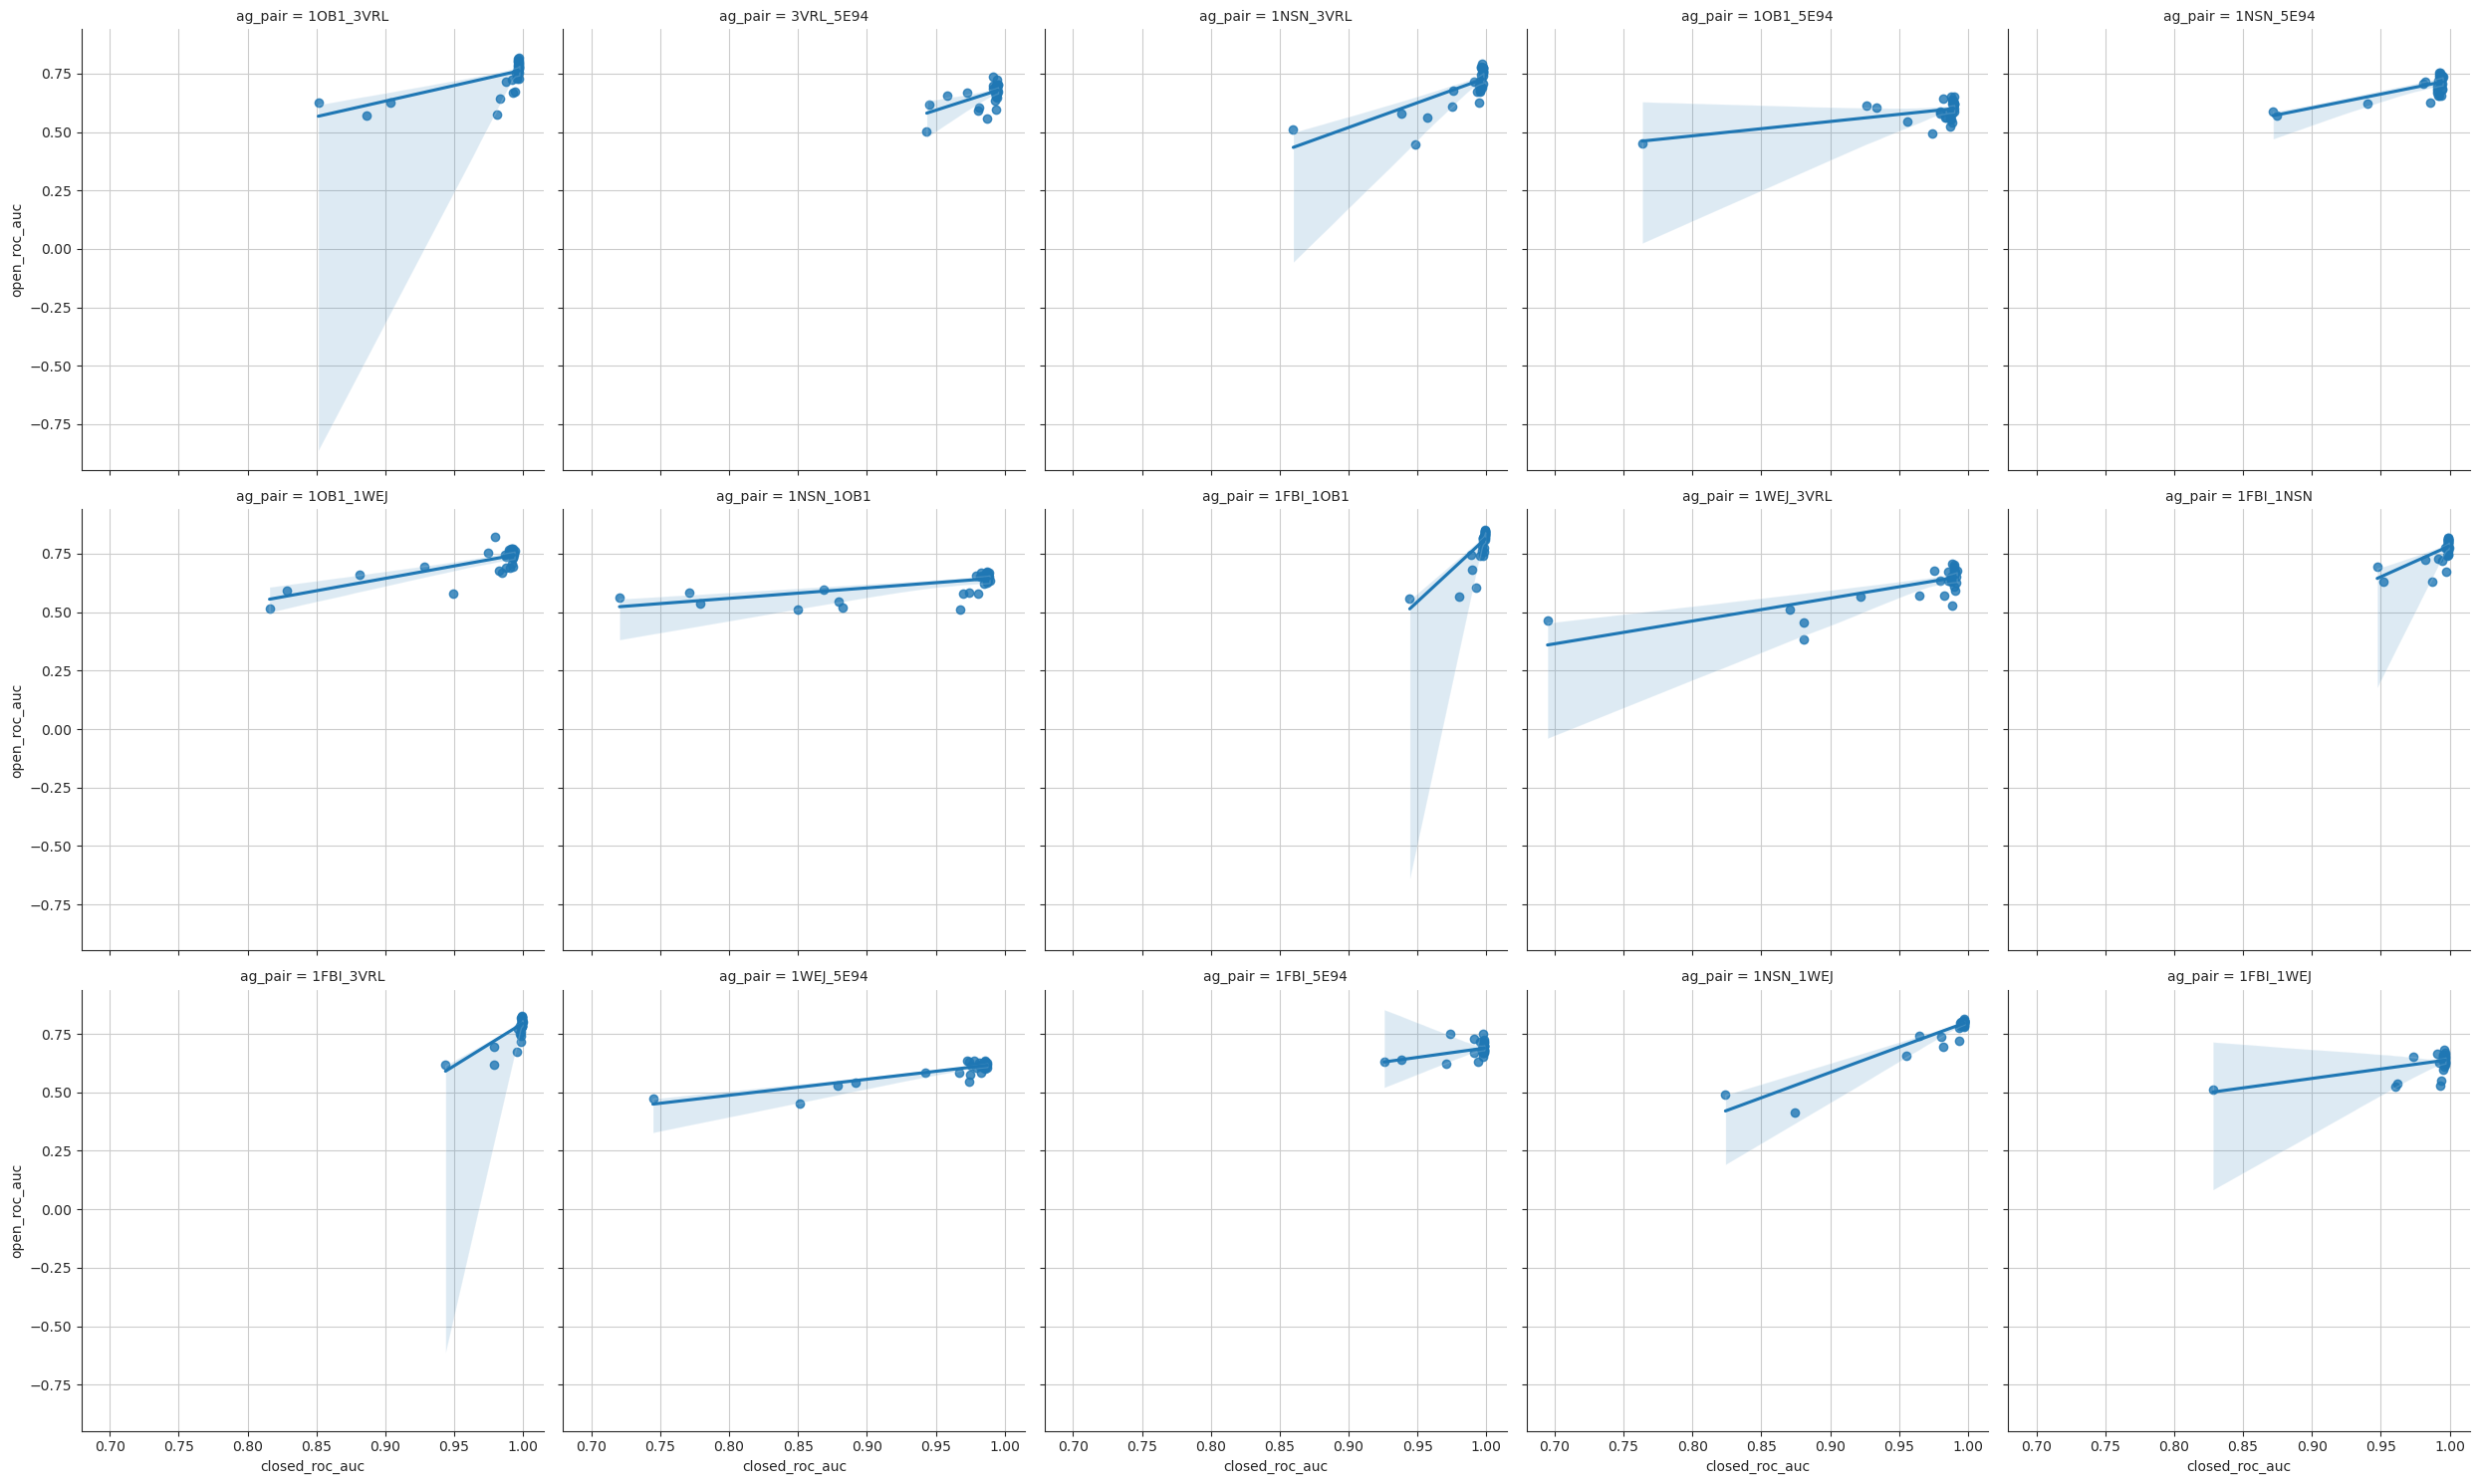

In [70]:
sns.set_style("ticks",{'axes.grid' : True})
sns.lmplot(
    data=df_cv,
    x="closed_roc_auc",
    y="open_roc_auc",
    col="ag_pair",
    col_wrap=5,
    height=5,
    sharex=True,
    # ci=None,
    robust=True,
)

<AxesSubplot:xlabel='Start Time', ylabel='closed_roc_auc'>

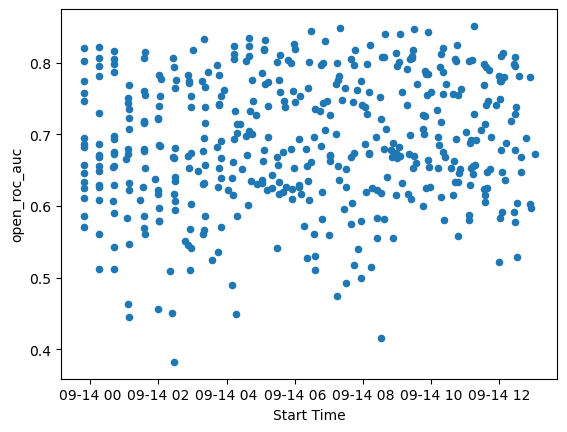

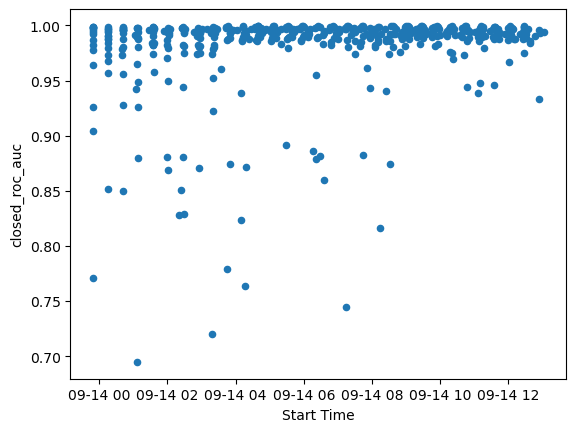

In [63]:
df_cv.plot.scatter(x="Start Time", y="open_roc_auc")
df_cv.plot.scatter(x="Start Time", y="closed_roc_auc")

In [121]:
assert set(df2.ag_pair) == set(df_tuned.ag_pair)
df2["experiment_id"] = "2"
df_tuned["experiment_id"] = "3"
df = pd.concat((df2, df_tuned), axis=0)
df.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,N_closed,N_open,...,train_loss,ag_pair,experiment_id,N_val,val_acc,val_f1,val_loss,val_precision,val_recall,val_roc_auc
0,2022-09-13 22:44:59,1.0h,8ad6dcfbb4f04a5095d42d02267353f1,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9111.0,131283.0,...,0.130873,1NSN_1OB1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-13 22:44:59,1.0h,ba6bc6ef056b4e139d5568383f3dc71d,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9197.0,131283.0,...,0.057250,1OB1_1WEJ,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-13 22:44:59,1.0h,9ba02c3ecbed4f34a951aa79e45206cd,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,8754.0,131283.0,...,0.277103,1WEJ_5E94,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-13 22:44:59,1.0h,c37592f8a17e434e88e0c313b56d00dc,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,8465.0,131283.0,...,0.000086,1FBI_1NSN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-13 22:44:59,1.1h,272bf49e83504694bfa53face3cdcae8,run_2,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,8968.0,131283.0,...,0.004703,1FBI_1OB1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# irrelevant as long as tuning doesn't help!
df_pivot = df.pivot(index="ag_pair", columns=["experiment_id"], values=["open_roc_auc"])
df_pivot = df_pivot.reset_index(drop=False)
df_pivot.columns = df_pivot.columns.droplevel(0)
df_pivot.columns.name = None
df_pivot.columns = ["ag_pair", "untuned", "tuned"]
df_pivot

,ag_pair,untuned,tuned
0,1FBI_1NSN,0.779620,0.817104
1,1FBI_1OB1,0.850378,0.853912
2,1FBI_1WEJ,0.624250,0.655275
3,1FBI_3VRL,0.831703,0.809454
4,1FBI_5E94,0.694935,0.698420
5,1NSN_1OB1,0.648281,0.633891
6,1NSN_1WEJ,0.790884,0.802006
7,1NSN_3VRL,0.757576,0.762564
8,1NSN_5E94,0.747426,0.711689
9,1OB1_1WEJ,0.730767,0.741234


<AxesSubplot:>

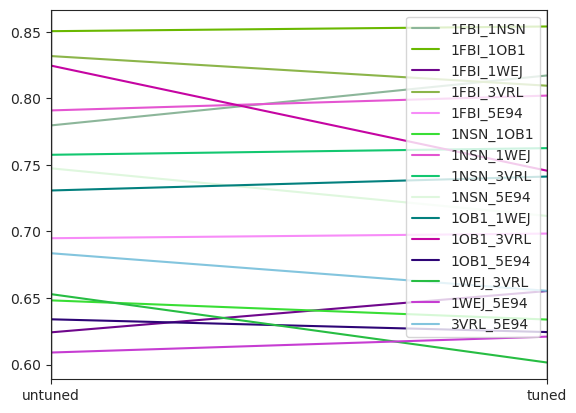

In [125]:
pd.plotting.parallel_coordinates(df_pivot, class_column="ag_pair")